# License

***

Copyright 2018 Lingyao Meng (danielle@h2o.ai), J. Patrick Hall (phall@h2o.ai), and the H2O.ai team. 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Imports and Setup

***

In [1]:
import os
import time
import sys

from data_maker_and_getter import DataMakerAndGetter
import eli5
import eli5.xgboost
import h2o
from lime_explainer import LIMEExplainer
import matplotlib.pyplot as plt
import numpy as np
from numpy import loadtxt
import pandas as pd
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [2]:
%matplotlib inline

In [3]:
# load JS visualization code to notebook
shap.initjs() 

In [4]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_112"; Java(TM) SE Runtime Environment (build 1.8.0_112-b16); Java HotSpot(TM) 64-Bit Server VM (build 25.112-b16, mixed mode)
  Starting server from /Users/phall/anaconda/lib/python3.5/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp98soypj3
  JVM stdout: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp98soypj3/h2o_phall_started_from_python.out
  JVM stderr: /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T/tmp98soypj3/h2o_phall_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.16.0.4
H2O cluster version age:,3 months and 10 days
H2O cluster name:,H2O_from_python_phall_op7cs0
H2O cluster total nodes:,1
H2O cluster free memory:,10.67 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


# Random Data Generation and XGBoost Training
***

In [5]:
ds_ = DataMakerAndGetter(nrows=200000)
random = ds_.make_random()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [6]:
y = 'target'
X = [name for name in random.columns if name not in [y,'row_id','function','cat1','cat2','cat3']]
print(X)

['num1', 'num2', 'num3', 'num4', 'num5', 'num6', 'num7', 'num8', 'num9', 'num10', 'num11', 'num12']


In [7]:
random[y] = random[y].asfactor()
rtrain, rvalid, _ = random.split_frame([0.4, 0.3], seed = 12345)
print(rtrain.shape)
print(rvalid.shape)

(80049, 17)
(59947, 17)


In [8]:
rtrain_pd = rtrain.as_data_frame()
rvalid_pd = rvalid.as_data_frame()

In [9]:
rtrain_dm = xgb.DMatrix(rtrain_pd[X],
                        rtrain_pd[y])
rvalid_dm = xgb.DMatrix(rvalid_pd[X],
                        rvalid_pd[y])

In [10]:
ave_y = rtrain_pd['target'].mean()
print(ave_y)

0.5012554810178765


In [11]:
params = {
     'base_score': ave_y,
     'booster': 'gbtree',
     'colsample_bytree': 0.5,
     'eta': 0.01,
     'eval_metric': 'auc',
     'max_depth': 18,
     'nthread': 4,
     'objective': 'binary:logistic',
     'reg_alpha': 0.01,
     'reg_lambda': 0.01,
     'seed': 12345,
     'silent': 0,
     'subsample': 0.1}

watchlist = [(rtrain_dm, 'train'), (rvalid_dm, 'eval')]

random_model = xgb.train(params, 
                         rtrain_dm, 
                         400,
                         evals=watchlist,
                         early_stopping_rounds=50,
                         verbose_eval=True)

[0]	train-auc:0.520328	eval-auc:0.499588
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.537317	eval-auc:0.499484
[2]	train-auc:0.546724	eval-auc:0.497683
[3]	train-auc:0.558478	eval-auc:0.496523
[4]	train-auc:0.566292	eval-auc:0.494748
[5]	train-auc:0.573791	eval-auc:0.495021
[6]	train-auc:0.578641	eval-auc:0.494205
[7]	train-auc:0.583626	eval-auc:0.493317
[8]	train-auc:0.590023	eval-auc:0.495211
[9]	train-auc:0.592495	eval-auc:0.495679
[10]	train-auc:0.597422	eval-auc:0.495982
[11]	train-auc:0.600691	eval-auc:0.495277
[12]	train-auc:0.603779	eval-auc:0.495072
[13]	train-auc:0.606444	eval-auc:0.495315
[14]	train-auc:0.60914	eval-auc:0.494968
[15]	train-auc:0.61277	eval-auc:0.495714
[16]	train-auc:0.614689	eval-auc:0.495971
[17]	train-auc:0.617701	eval-auc:0.496398
[18]	train-auc:0.620587	eval-auc:0.496135
[19]	train-auc:0.623016	eval-auc:0.497187
[20]	train-auc:0.624878	eval-au

# Global Variable Importance 

***

#### XGBoost variable importance

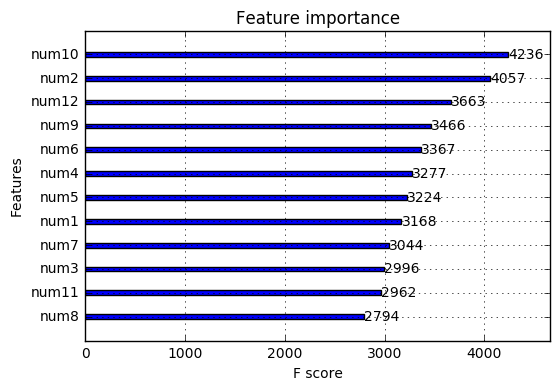

In [12]:
_ = plot_importance(random_model)

#### Eli5/Tree Interpreter variable importance

In [13]:
eli5.show_weights(random_model)

Weight,Feature
0.0849,num12
0.0846,num8
0.0842,num3
0.0839,num5
0.0834,num4
0.0833,num6
0.0831,num11
0.0830,num9
0.0827,num10
0.0826,num1


#### Shapley variable importance

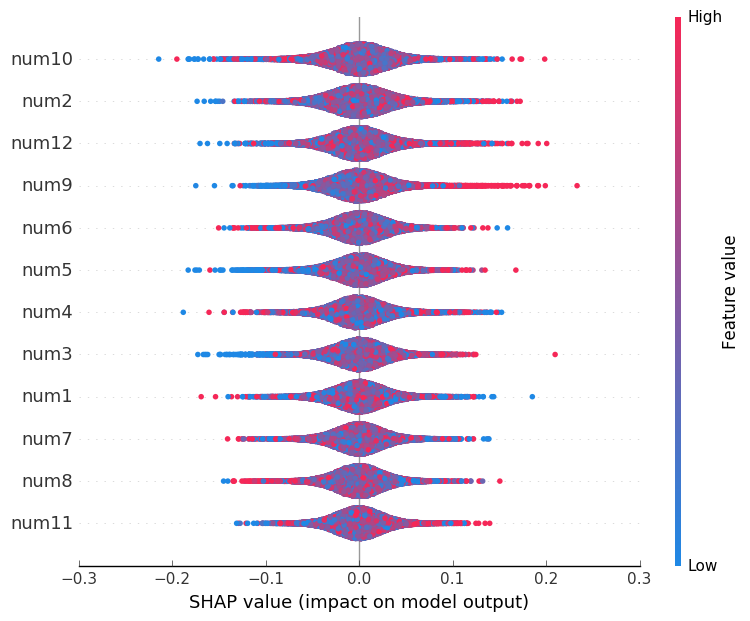

In [14]:
shap_values = random_model.predict(rvalid_dm, pred_contribs=True)
shap.summary_plot(shap_values, rvalid_pd[X])

#### Example Shapley dependence (you can try other variables)

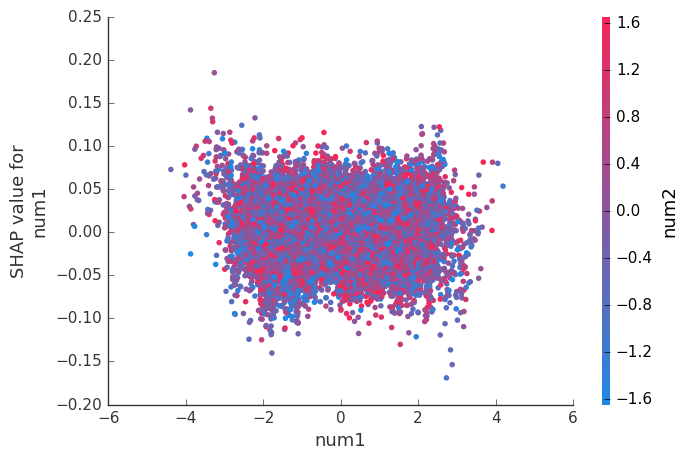

In [15]:
var = "num1" 
shap.dependence_plot(var, shap_values, rvalid_pd[X])

# Local Explanations (variable importance) at Several Percentiles of Model Predictions

***

#### Bind XGBoost predictions to training data

In [16]:
random_preds = pd.DataFrame(random_model.predict(rvalid_dm))

In [17]:
random_decile_frame = pd.concat([rvalid_pd, random_preds], axis=1)
random_decile_frame = random_decile_frame.rename(columns={0: 'predict'})
random_decile_hframe = h2o.H2OFrame(random_decile_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
random_decile_frame.head()

,num1,num2,num3,num4,num5,num6,num7,num8,num9,num10,num11,num12,cat1,cat2,cat3,target,row_id,predict
0,0.274992,0.228913,1.352917,0.886429,-2.001637,-0.371843,1.669025,-0.438570,-0.539741,0.476985,3.248944,-1.021228,GGGGGGGG,CCCCCCCC,BBBBBBBB,0,1,0.472105
1,0.331286,1.349742,0.069877,0.246674,-0.011862,1.004812,1.327195,-0.919262,-1.549106,0.022185,0.758363,-0.660524,DDDDDDDD,AAAAAAAA,DDDDDDDD,1,4,0.511642
2,0.862580,-0.010032,0.050009,0.670216,0.852965,-0.955869,-0.023493,-2.304234,-0.652469,-1.218302,-1.332610,1.074623,BBBBBBBB,CCCCCCCC,AAAAAAAA,1,5,0.515896
3,0.723642,0.690002,1.001543,-0.503087,-0.622274,-0.921169,-0.726213,0.222896,0.051316,-1.157719,0.816707,0.433610,CCCCCCCC,GGGGGGGG,FFFFFFFF,0,6,0.490903
4,-2.252797,-1.166832,0.353607,0.702110,-0.274569,-0.139142,0.107657,-0.606545,-0.417064,-0.017007,-1.224145,-1.800840,FFFFFFFF,DDDDDDDD,CCCCCCCC,0,10,0.510169


#### Find percentiles of XGBoost predictions

In [19]:
random_percentile_dict = ds_.get_percentile_dict('predict', 'row_id', random_decile_hframe)

In [20]:
random_percentile_dict

{0: 70045,
 10: 34373,
 20: 127457,
 30: 43421,
 40: 96230,
 50: 177522,
 60: 73336,
 70: 198144,
 80: 179619,
 90: 85638,
 99: 72726}

# Explanation at each decile

#### Utility function that displays the TreeInterpreter plot at the chosen decile 

In [21]:
def eli5_dd(decile):
    row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]
    return eli5.explain_prediction_xgboost(random_model,row[X].iloc[0])

#### Utility function that displays the LIME result at the choosen decile

In [22]:
explainer = LIMEExplainer(training_frame=rvalid_pd, X=X, model=random_model, discretize=None)

def lime(decile):
    row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]
    explainer.explain(row.index[0]) 

##  10th decile of model predictions

In [23]:
decile = 10
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num1                         -0.012647
num2                         -0.021609
num3                         -0.016245
num4                         -0.020893
num5                          0.007495
num6                         -0.004738
num7                         -0.007088
num8                         -0.026082
num9                         -0.010359
num10                        -0.005087
num11                        -0.012019
num12                         0.006573 

Shapley sum:  -0.115634
Model prediction:  -0.115633534597


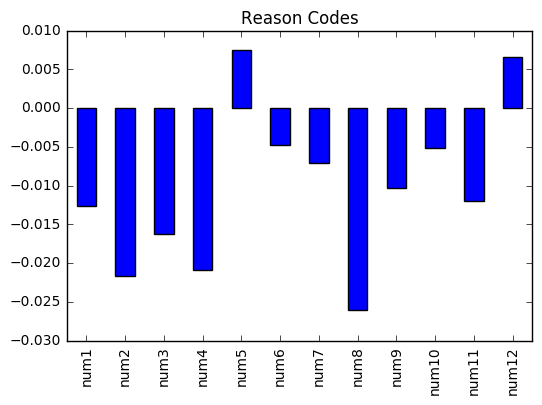

In [24]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter

In [25]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x1268f8048>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num5', weight=0.007495010464418337, std=None, value=0.64014989334403027), FeatureWeight(feature='num12', weight=0.0065730139045461202, std=None, value=-0.46457478408706637), FeatureWeight(feature='<BIAS>', weight=0.0020453026915078928, std=None, value=1.0)], neg=[FeatureWeight(feature='num8', weight=-0.026082469945892039, std=None, value=-0.24075454176924049), FeatureWeight(feature='num2', weight=-0.0216094058916417, std=None, value=-0.86082634875393071), FeatureWeight(feature='num4', weight=-0.020893330989272044, std=None, value=-0.58378738822561571), FeatureWeight(feature='num3', weight=-0.016245079974589349, std=None, value=1.1954514975557589), FeatureWeight(feature='num1', weight=-0.01264668464275634, std=None, value=0.47847554394462211), FeatureWeight(feature='num11', weight=-0.01201926446425447, std=None, value=-0.10557779301364606), FeatureWeight(feature='num9', weight=-0.010359492503318812, std=None, value=0.25881196968033743), FeatureWeight(feature='num7', weight=-0.0070876883170134311, std=None, value=-0.63566009786132027), FeatureWeight(feature='num10', weight=-0.0050870429423479609, std=None, value=-0.17481627076060635), FeatureWeight(feature='num6', weight=-0.0047382293593862057, std=None, value=-0.86578347837624758)], pos_remaining=0, neg_remaining=0), proba=None, score=-0.12065536196999994, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [26]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  -0.115633534597


### LIME


Model Prediction: 0.47
Local GLM Prediction: 0.50
Local GLM R-square: 0.18
Local GLM Intercept: 0.49

Approximate Local Contributions:
   Input  Local Contribution
0   num2       -6.435593e-04
1   num4       -4.288169e-10
2   num6       -5.522773e-14
3   num7       -3.728994e-16
4   num8       -4.970105e-18
5  num11       -1.829609e-19
6   num5        4.393642e-12
7   num3        5.058349e-05
8   num1        4.381251e-03
None


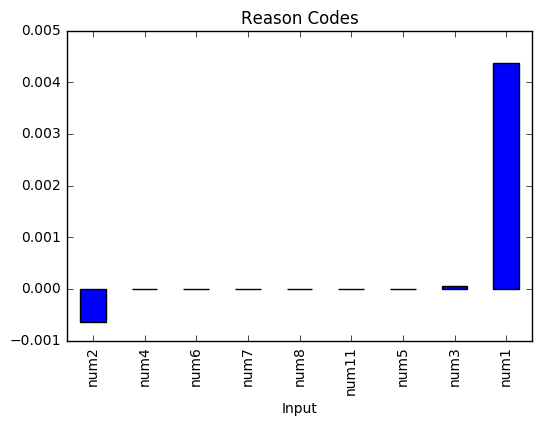

In [27]:
lime(decile)

##  Median of predictions

In [28]:
decile = 50
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num1                          0.000648
num2                          0.004779
num3                         -0.008398
num4                          0.019670
num5                          0.001462
num6                         -0.026295
num7                          0.010595
num8                         -0.034767
num9                          0.009702
num10                        -0.008693
num11                         0.021961
num12                         0.010286 

Shapley sum:  0.00801896
Model prediction:  0.00801901346083


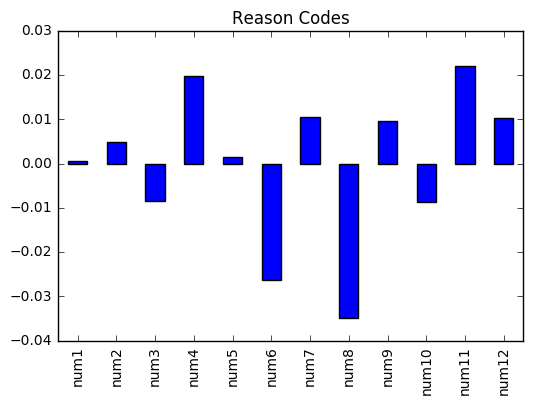

In [29]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter 

In [30]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x1268f8048>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num11', weight=0.021961427757782839, std=None, value=-0.85913351891072842), FeatureWeight(feature='num4', weight=0.019670198705577714, std=None, value=-0.19363787065285604), FeatureWeight(feature='num7', weight=0.010595193925395466, std=None, value=-0.35413124486215108), FeatureWeight(feature='num12', weight=0.010286498504989257, std=None, value=0.01455712030095754), FeatureWeight(feature='num9', weight=0.0097017041621140169, std=None, value=1.2529831785542391), FeatureWeight(feature='num2', weight=0.0047791264413133841, std=None, value=-1.3473236309982308), FeatureWeight(feature='<BIAS>', weight=0.0020453026915078928, std=None, value=1.0), FeatureWeight(feature='num5', weight=0.0014621191506981987, std=None, value=1.1692546446365375), FeatureWeight(feature='num1', weight=0.00064827816657047406, std=None, value=-0.9056319823604464)], neg=[FeatureWeight(feature='num8', weight=-0.034766900908661656, std=None, value=-1.0027999561709291), FeatureWeight(feature='num6', weight=-0.026294554988880042, std=None, value=0.29299171937032531), FeatureWeight(feature='num10', weight=-0.0086927596986990791, std=None, value=0.45340216004659811), FeatureWeight(feature='num3', weight=-0.0083984365097084755, std=None, value=0.11472099998973058)], pos_remaining=0, neg_remaining=0), proba=None, score=0.0029971974000000236, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [31]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.00801901346083


### LIME


Model Prediction: 0.50
Local GLM Prediction: 0.51
Local GLM R-square: 0.03
Local GLM Intercept: 0.51

Approximate Local Contributions:
   Input  Local Contribution
0   num1       -3.874788e-03
1   num2       -2.374519e-06
2   num4       -6.145393e-12
3  num11       -2.244683e-18
4   num7       -3.061708e-19
5   num9        4.330759e-18
6   num6        1.665175e-16
7   num5        1.580884e-13
8   num3        8.619816e-10
None


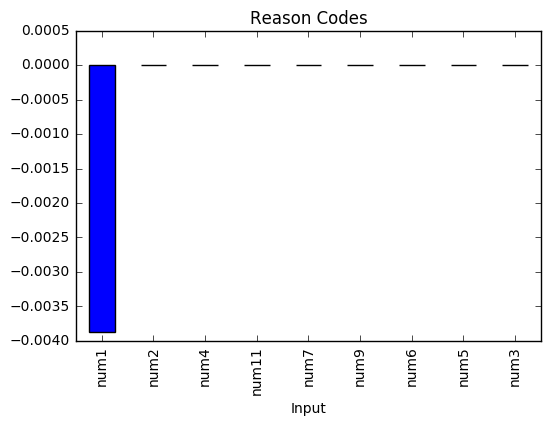

In [32]:
lime(decile)

##  90th decile of model predictions

In [33]:
decile = 90
row = random_decile_frame[random_decile_frame['row_id'] == random_percentile_dict[decile]]

### Shapley values

       Approximate Local Contributions
num1                         -0.012955
num2                         -0.010919
num3                          0.012091
num4                          0.045071
num5                          0.039083
num6                         -0.019528
num7                         -0.064451
num8                          0.010403
num9                          0.038497
num10                         0.010862
num11                         0.027122
num12                         0.049070 

Shapley sum:  0.131413
Model prediction:  0.131412468657


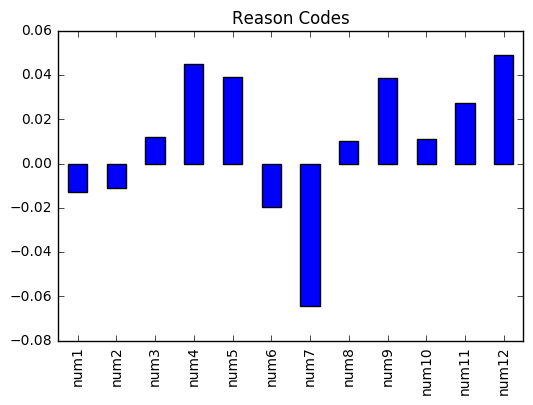

In [34]:
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(12, 1), columns=['Approximate Local Contributions'], index=X)
print(s_df, '\n')
_= s_df.plot(kind='bar', title='Reason Codes', legend=False)
print('Shapley sum: ', s_df['Approximate Local Contributions'].sum() + shap_values[row.index[0], -1])
p = row['predict'].values[0]
print('Model prediction: ', np.log(p/(1 - p)))

### TreeInterpreter

In [35]:
eli5_dd(decile)

Explanation(estimator='<xgboost.core.Booster object at 0x1268f8048>', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=True, targets=[TargetExplanation(target='y', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='num12', weight=0.049070291710366691, std=None, value=0.49152781420978692), FeatureWeight(feature='num4', weight=0.045070565729740365, std=None, value=0.065565800233799987), FeatureWeight(feature='num5', weight=0.039083257695281218, std=None, value=0.11378878460615395), FeatureWeight(feature='num9', weight=0.038497461663340574, std=None, value=0.16526007266411522), FeatureWeight(feature='num11', weight=0.027121802369830701, std=None, value=0.97660874811645115), FeatureWeight(feature='num3', weight=0.012090590088494144, std=None, value=-0.77219679641372452), FeatureWeight(feature='num10', weight=0.01086228718260503, std=None, value=-2.4574001599006965), FeatureWeight(feature='num8', weight=0.010402552032247412, std=None, value=-1.2464402230191864), FeatureWeight(feature='<BIAS>', weight=0.0020453026915078928, std=None, value=1.0)], neg=[FeatureWeight(feature='num7', weight=-0.06445072179314075, std=None, value=0.4926924019852012), FeatureWeight(feature='num6', weight=-0.019528199124917801, std=None, value=-2.4277967915165295), FeatureWeight(feature='num1', weight=-0.012954869488576003, std=None, value=-1.6745193646814664), FeatureWeight(feature='num2', weight=-0.010919384456779459, std=None, value=-1.4221268546158592)], pos_remaining=0, neg_remaining=0), proba=None, score=0.12639093629999992, weighted_spans=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None)

In [36]:
p = row['predict'].values[0]
print('\nModel prediction: ', np.log(p/(1 - p)))


Model prediction:  0.131412468657


### LIME


Model Prediction: 0.53
Local GLM Prediction: 0.49
Local GLM R-square: 0.03
Local GLM Intercept: 0.50

Approximate Local Contributions:
   Input  Local Contribution
0   num1       -8.081351e-03
1   num2       -3.186049e-06
2   num3       -8.315696e-09
3   num6       -2.871107e-15
4  num10       -2.340336e-17
5   num9        2.854437e-19
6   num5        2.802803e-14
7   num4        3.362463e-12
None


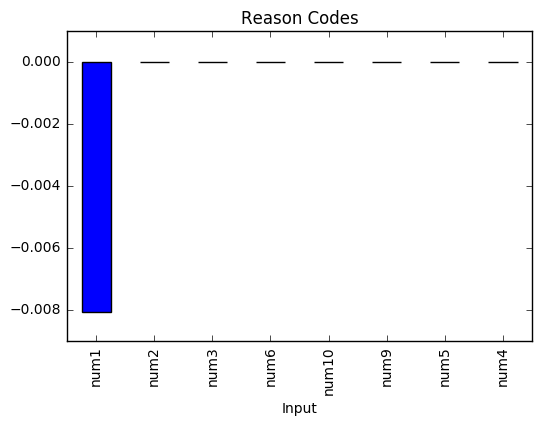

In [37]:
lime(decile)